15    MULTIPOLYGON (((914275.727 3296426.14, 914367....
Name: geometry, dtype: geometry


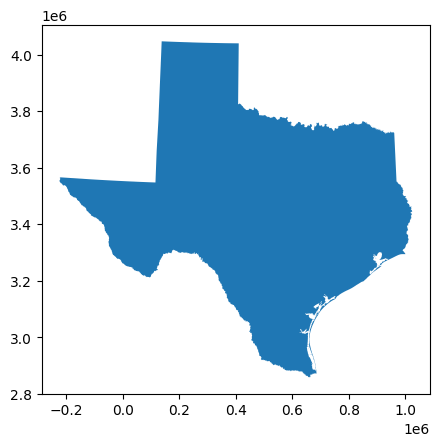

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import Polygon
import math

# Load US states shapefile from the Census Bureau
states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")

# Filter for Texas
texas = states[states['NAME'] == 'Texas']

texasMeters = texas.geometry.to_crs(epsg=32614)

# Get the polygon geometry
texas_poly = texasMeters.geometry.iloc[0]

minx, miny, maxx, maxy = texas_poly.bounds

# Print or visualize
print(texas_poly)
texas.plot()

radius = 1000

roadDf = gpd.read_parquet("../../data/raw/texas_edges.parquet", columns=["geometry"])

roadDf = roadDf.to_crs(epsg=32614)

In [ ]:
def createHexagon(x, y, radius):
    polygonPoints = []
    for angle in range(0, 360, 60):
        radian = math.radians(angle)
        xPart = x + radius * math.cos(radian)
        yPart = y + radius * math.sin(radian)
        polygonPoints.append((xPart, yPart))
    return Polygon(polygonPoints)

def createCells(startingX, endingX, startingY, endingY, radius):
    cellList = []
    for x in np.arange(startingX, endingX + radius / 2, 3*radius):
        for y in np.arange(startingY, endingY + radius / 2, 2 * radius * math.sqrt(3) / 2):
            cellList.append(createHexagon(x, y, radius))
    cellDf = gpd.GeoDataFrame(geometry=cellList, index=None, crs = texasMeters.crs)
    return cellDf

allCells = createCells(minx, maxx, miny, maxy, radius)

minx += radius * 1.5
# not the full index, more like part of the way there, so
miny += radius * math.sqrt(3) / 2

secondHex = createCells(minx, maxx, miny, maxy, radius)

allCells = pd.concat([allCells, secondHex], ignore_index=True)

texasDf = gpd.GeoDataFrame(geometry=[texas_poly], crs = allCells.crs)

hexesinTexas = gpd.sjoin(allCells, texasDf, predicate="intersects")

hexesWithCells = gpd.sjoin(hexesinTexas, roadDf, predicate="intersects")

hexesWithCells = hexesWithCells.drop(columns=["index_right"])

hexesWithCells.to_parquet("../../data/processed/cells.parquet")